# Hadamard Test with U(Quantum Fourier Transform) on Different Shots
by <a href="https://www.linkedin.com/in/la-wun-nannda-b047681b5/">`La Wun Nannda`</a>

## Import Libaries

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from classiq import *

In [2]:
# initiate a session
authenticate()

C:\Users\ASUS\anaconda3\envs\qiskit_env\Lib\site-packages\classiq\_internals\authentication\token_manager.py:99: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


## Hadamard Test with U(QFT) Function

In [3]:
@qfunc
def main(expectation_value: Output[QBit]):
    # allocate qubits
    allocate(1, expectation_value)
    psi = QNum("psi")
    allocate(4, psi)

    # hadamard test circuit
    H(expectation_value)
    control(ctrl=(expectation_value), operand=lambda: qft(psi)) # QFT implementation
    H(expectation_value)

## Building, Programming, and Executing a Model

In [4]:
# create a model
quantum_model = create_model(main)

# different shots
shots = [1000, 2000, 4000, 8000, 16000]

# storage for output
results = []

# execute the model
for shot in shots:
    print("shot:", shot)
    quantum_model_customized = set_execution_preferences(
        quantum_model,
        execution.ExecutionPreferences(
            num_shots=shot, job_name=f"Hadamard test with {shot} shots", random_seed=767
        ),
    )

    # synthesize
    quantum_program = synthesize(quantum_model_customized)

    # execute
    job = execute(quantum_program)
    result = job.result()[0].value
    print(result.parsed_counts,'\n')
    results.append(result.counts)

shot: 1000
[{'expectation_value': 0.0}: 602, {'expectation_value': 1.0}: 398] 

shot: 2000
[{'expectation_value': 0.0}: 1220, {'expectation_value': 1.0}: 780] 

shot: 4000
[{'expectation_value': 0.0}: 2451, {'expectation_value': 1.0}: 1549] 

shot: 8000
[{'expectation_value': 0.0}: 4959, {'expectation_value': 1.0}: 3041] 

shot: 16000
[{'expectation_value': 0.0}: 9956, {'expectation_value': 1.0}: 6044] 



In [5]:
# check counts
results

[{'1': 398, '0': 602},
 {'1': 780, '0': 1220},
 {'0': 2451, '1': 1549},
 {'1': 3041, '0': 4959},
 {'1': 6044, '0': 9956}]

## Checking P(0)

In [6]:
# probability function
# P(i) = number of occurrences of 'i'/total possible occurrences
def checkP(list_of_counts):
    P0 = []
    for i in list_of_counts:
        print("P(0): ",i[str(0)]/(i[str(0)]+i[str(1)]),", P(1): ",i[str(1)]/(i[str(0)]+i[str(1)]))
        P0.append(i[str(0)]/(i[str(0)]+i[str(1)]))
    return P0

In [7]:
# check probabilities of zero, P(0), for different shots
p = checkP(results)

P(0):  0.602 , P(1):  0.398
P(0):  0.61 , P(1):  0.39
P(0):  0.61275 , P(1):  0.38725
P(0):  0.619875 , P(1):  0.380125
P(0):  0.62225 , P(1):  0.37775


## Calculate Re{<0| U<sub>QFT</sub> |0>}
- ### Theoretically
    Let abbreviate U<sub>QFT</sub> as U. We eliminate complex parts since we are interested in real numbers.

    $U|0\rangle = \frac{1}{\sqrt{2^n}}\sum_{y=0}^{2^n-1}|y\rangle$

    We are using a four-qubit system. So `n=4`.

    $U|0000\rangle = \frac{1}{\sqrt{2^4}}\sum_{y=0}^{2^4-1}|y\rangle$

    $U|0000\rangle = \frac{1}{4}\sum_{y=0}^{15}|y\rangle$

    This can be extended as follows-

    $U|0000\rangle = \frac{1}{4}(|0000\rangle+|0001\rangle+|0010\rangle+|0011\rangle+|0100\rangle+|0101\rangle+|0110\rangle+|0111\rangle+|1000\rangle+|1001\rangle+|1010\rangle+|1011\rangle+|1100\rangle+|1101\rangle+|1110\rangle+|1111\rangle)$

    For convinence, we will stick with `y`.

    $\langle0000|U|y\rangle = \frac{1}{4}\langle0000|y\rangle$

    While evaluating $\langle0000|y\rangle$, anything except `y=0000` results in 0 and $\langle0000|0000\rangle = 1$.

    $\langle0000|U|0000\rangle = \frac{1}{4} = 0.25$

- ### Experimentally
Using the equation: Re {<0| U<sub>QFT</sub> |0>} = 2P<sub>0</sub> - 1

In [8]:
# function
def calculateQFT(probabilities):
    answers = [ ]
    for i in probabilities:
        answers.append((2*i) - 1)
    return answers

In [9]:
# evaluate QFT
answers = calculateQFT(p)
answers

[0.20399999999999996,
 0.21999999999999997,
 0.22550000000000003,
 0.2397499999999999,
 0.24449999999999994]

## Plotting

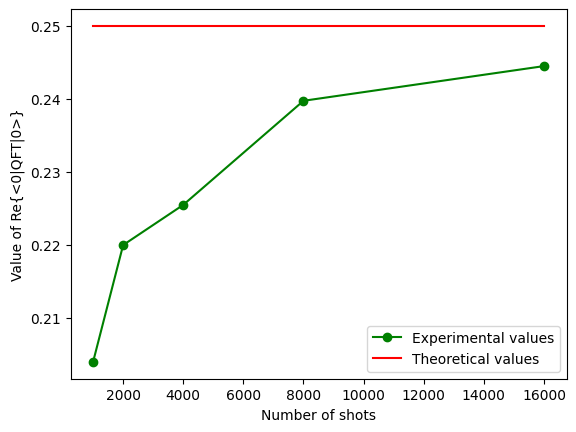

In [10]:
x = shots
y1 = answers
y2 = [0.25 for i in range(len(y1))]
plt.plot(x, y1, 'go-')
plt.plot(x, y2, 'r-')
plt.legend(["Experimental values", "Theoretical values"], loc="lower right")
plt.xlabel("Number of shots")
plt.ylabel("Value of Re{<0|QFT|0>}")
plt.show()

# Multiple Executions of H Test and QFT
Due to quantum nature, there maybe a slight variation in each execution of a program. Here, we test this by looping an execution for each shot 5 times. This results in a total of 25 executions since there are also 5 shots.

In [11]:
n = 5 # iterate the process 5 times for each shot

# storage for output
list_of_results = []

# iterate each shot
for shot in shots:
    results = []
    print("shot:", shot)
    for i in range(n): # execute 'n' times
        # set model
        quantum_model_customized = set_execution_preferences(
            quantum_model,
            execution.ExecutionPreferences(
                num_shots=shot, job_name=f"{shot} shots H test - {n}", 
            ),
        )
        
        # synthesize
        quantum_program = synthesize(quantum_model_customized)
        
        # execute
        job = execute(quantum_program)
        result = job.result()[0].value
        results.append(result.counts)
    
    list_of_results.append(results)

shot: 1000
shot: 2000
shot: 4000
shot: 8000
shot: 16000


We can verify the probablistic nature as follows. We can see that within each shot (1000, 2000, 4000, 8000, 16000), there are different outcomes.

In [12]:
# check the list containing counts for 5 iterations for each shot (1000, 2000, 4000, 8000, 16000)
list_of_results

[[{'0': 619, '1': 381},
  {'0': 650, '1': 350},
  {'1': 385, '0': 615},
  {'1': 410, '0': 590},
  {'1': 379, '0': 621}],
 [{'0': 1221, '1': 779},
  {'1': 754, '0': 1246},
  {'1': 720, '0': 1280},
  {'0': 1253, '1': 747},
  {'1': 785, '0': 1215}],
 [{'0': 2500, '1': 1500},
  {'1': 1515, '0': 2485},
  {'1': 1459, '0': 2541},
  {'0': 2488, '1': 1512},
  {'1': 1526, '0': 2474}],
 [{'1': 2986, '0': 5014},
  {'1': 3053, '0': 4947},
  {'1': 3010, '0': 4990},
  {'1': 2897, '0': 5103},
  {'1': 3065, '0': 4935}],
 [{'1': 6065, '0': 9935},
  {'1': 5918, '0': 10082},
  {'1': 6025, '0': 9975},
  {'1': 6052, '0': 9948},
  {'1': 6016, '0': 9984}]]

In [13]:
# convert to probabilities, calculate the final answers, and store
total_QFTs = []
i = 1000
for each_shot in list_of_results:
    print(f">>>shot {i}")
    each_p = checkP(each_shot) # convert counts into probabilities # store only the P(0) for each shot 
    eachQFT = calculateQFT(each_p) # calculate QFT
    print(f"QFT for shot {i}:", eachQFT)
    total_QFTs.append(eachQFT) # store QFT
    i = i*2 # for indexing
    print("")

>>>shot 1000
P(0):  0.619 , P(1):  0.381
P(0):  0.65 , P(1):  0.35
P(0):  0.615 , P(1):  0.385
P(0):  0.59 , P(1):  0.41
P(0):  0.621 , P(1):  0.379
QFT for shot 1000: [0.238, 0.30000000000000004, 0.22999999999999998, 0.17999999999999994, 0.242]

>>>shot 2000
P(0):  0.6105 , P(1):  0.3895
P(0):  0.623 , P(1):  0.377
P(0):  0.64 , P(1):  0.36
P(0):  0.6265 , P(1):  0.3735
P(0):  0.6075 , P(1):  0.3925
QFT for shot 2000: [0.22100000000000009, 0.246, 0.28, 0.2529999999999999, 0.21500000000000008]

>>>shot 4000
P(0):  0.625 , P(1):  0.375
P(0):  0.62125 , P(1):  0.37875
P(0):  0.63525 , P(1):  0.36475
P(0):  0.622 , P(1):  0.378
P(0):  0.6185 , P(1):  0.3815
QFT for shot 4000: [0.25, 0.24249999999999994, 0.27049999999999996, 0.244, 0.2370000000000001]

>>>shot 8000
P(0):  0.62675 , P(1):  0.37325
P(0):  0.618375 , P(1):  0.381625
P(0):  0.62375 , P(1):  0.37625
P(0):  0.637875 , P(1):  0.362125
P(0):  0.616875 , P(1):  0.383125
QFT for shot 8000: [0.25350000000000006, 0.23675000000000002, 

In [14]:
# check answers
total_QFTs

[[0.238, 0.30000000000000004, 0.22999999999999998, 0.17999999999999994, 0.242],
 [0.22100000000000009, 0.246, 0.28, 0.2529999999999999, 0.21500000000000008],
 [0.25, 0.24249999999999994, 0.27049999999999996, 0.244, 0.2370000000000001],
 [0.25350000000000006,
  0.23675000000000002,
  0.24750000000000005,
  0.27574999999999994,
  0.2337499999999999],
 [0.24187500000000006,
  0.2602500000000001,
  0.24687499999999996,
  0.24350000000000005,
  0.248]]

## Plotting Multiple Executions

In [15]:
# sort the values in each shot to connect endpoints to draw a vertical line
total_QFTs_sorted = []
for i in total_QFTs:
    total_QFTs_sorted.append(sorted(i))
total_QFTs_sorted

[[0.17999999999999994, 0.22999999999999998, 0.238, 0.242, 0.30000000000000004],
 [0.21500000000000008, 0.22100000000000009, 0.246, 0.2529999999999999, 0.28],
 [0.2370000000000001, 0.24249999999999994, 0.244, 0.25, 0.27049999999999996],
 [0.2337499999999999,
  0.23675000000000002,
  0.24750000000000005,
  0.25350000000000006,
  0.27574999999999994],
 [0.24187500000000006,
  0.24350000000000005,
  0.24687499999999996,
  0.248,
  0.2602500000000001]]

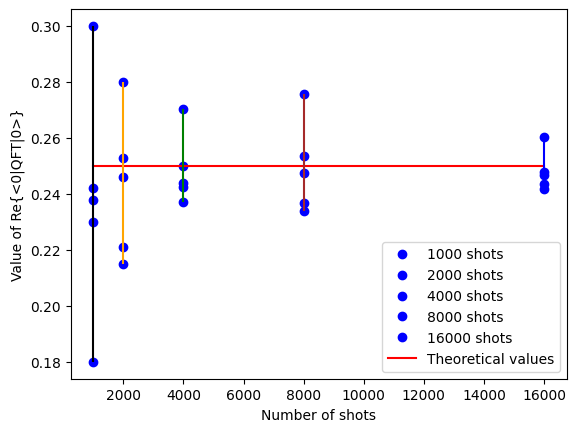

In [16]:
x = shots
y1 = total_QFTs_sorted # use the sorted value
y2 = [0.25 for i in range(len(y1))]

# zip endpoints to make vertical lines
lines = []
for i, j in zip(x,y1):
    pair = [(i, j[0]), (i, j[-1])]
    lines.append(pair)
linecoll = mpl.collections.LineCollection(lines, colors=['black','orange', 'green', 'brown', 'blue']) # make different colors for each shot

# draw figure
fig, ax = plt.subplots()
ax.plot(x, y1, 'bo')
ax.plot(x, y2, 'r-')
ax.add_collection(linecoll)

ax.legend(["1000 shots", "2000 shots", "4000 shots", "8000 shots", "16000 shots", "Theoretical values"], loc="lower right")
ax.set_xlabel("Number of shots")
ax.set_ylabel("Value of Re{<0|QFT|0>}")

plt.show()

# Conclusion
We find that an increase in the number of shots results in the experimental answers approaching to the theoretical value. Thus, we can conclude that the huge number of shots yield higher accuracy.